In [1]:
"""PLOT CARTESIAN ELLIPSE BY DIRECT PLOT"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from __future__ import division
import meshpy.triangle as triangle

In [2]:
#Abscisse
N = 10000
x = np.linspace(-10,10,N)

In [3]:
def defined_vector(y,x):
    """prepare the list (our ellispes) to be ready for mesh generation"""
    indexy=np.argwhere(np.isnan(y)==False) #find "nan" in the list
    NY=len(indexy) 
    c=((indexy[0]).tolist())[0]
    d= ((indexy[NY-1]).tolist())[0]
    yDEF=[]
    xDEF=[]
    for i in list(range(c, d+1)):
        yDEF.append((y[i]))
        xDEF.append((x[i]))
    #c = where the definition begins, d = where the definition ends, yDEF is the vector without nan values
    return yDEF,xDEF,c,d  

In [4]:
#general - ellipse centered on x0,y0 with main axis a and small axis b, angle of rotation alpha

def general_ellipse(x0,y0,a,b,alpha):
    A = (b**2)*(np.sin(alpha)**2)+(a**2)*(np.cos(alpha)**2)
    B = 2*(x-x0)*np.cos(alpha)*np.sin(alpha)*((b**2)-(a**2))
    C = ((x-x0)**2)*((b**2)*(np.cos(alpha)**2)+(a**2)*(np.sin(alpha)**2))-(a**2)*(b**2)
    y = (y0 + (-B+np.sqrt(B**2-4*A*C))/(2*A))
    z = (y0 + (-B-np.sqrt(B**2-4*A*C))/(2*A))
        
    yDEF,xDEFY,c,d=defined_vector(y,x)
    zDEF,xDEFZ,e,f=defined_vector(z,x)
    
    #need to inverse the positive part to make the mesh work
    N=len(yDEF)
    Y1=list(reversed(yDEF))
    X1=list(reversed(xDEFY))
    
    Ellipse=[] #big list of tuples [(x,y)]
    for i in range(N):
        Ellipse.append((X1[i],Y1[i]))#add a tuple to the list
    for i in range(len(zDEF)):
        Ellipse.append((xDEFZ[i],zDEF[i])) #add a tuple to the list
        
    return y,z,Ellipse #Ellipse is used to plot the contour and the mesh, y and z are needed to check if there intersections

In [5]:
def artery_wall_in(a_wall_in,b_wall_in):
    return general_ellipse(0,0,a_wall_in,b_wall_in,0)

def artery_wall_out(a_wall_out,b_wall_out):
    return general_ellipse(0,0,a_wall_out,b_wall_out,0)

def lumen(x_L,a_L,b_L):
    return general_ellipse(x_L,0,a_L,b_L,0)

def calcium(x_cal,y_cal,a_cal,b_cal,alpha_cal):
    return general_ellipse(x_cal,y_cal,a_cal,b_cal,alpha_cal)

def lipid(x_lip,y_lip,a_lip,b_lip,alpha_lip):
    return general_ellipse(x_lip,y_lip,a_lip,b_lip,alpha_lip)

In [6]:
def cross_two_graphs(y,z):
    """check if two graphs cross each other"""
    idx = np.intersect1d(np.argwhere(np.isnan(y)==False),np.argwhere(np.isnan(z)==False)) #abscisses where both graph are simultaneously determined 
    if np.argwhere(np.diff(np.sign(y[idx]-z[idx])) != 0).size>0 :
        return True
    else: 
        return False

def check_intersection_two_ellipses(y1,z1,y2,z2):
    """check if two ellispses (4 graphs) cross each other"""
    if cross_two_graphs(y1,y2):
        return True
    elif cross_two_graphs(y1,z2):
        return True
    elif cross_two_graphs(z1,y2):
        return True
    elif cross_two_graphs(z1,z2):
        return True
    
def check_intersection_all_ellipses(y_wall_in,z_wall_in,y_lumen,z_lumen,y_lipid,z_lipid,y_calcium,z_calcium):
    """check if any pair of ellispses (6 ellipses) cross each other"""
    if check_intersection_two_ellipses(y_wall_in,z_wall_in,y_lumen,z_lumen):
        return True
    elif check_intersection_two_ellipses(y_wall_in,z_wall_in,y_lipid,z_lipid):
        return True
    elif check_intersection_two_ellipses(y_wall_in,z_wall_in,y_calcium,z_calcium):
        return True
    elif check_intersection_two_ellipses(y_lumen,z_lumen,y_lipid,z_lipid):
        return True 
    elif check_intersection_two_ellipses(y_lumen,z_lumen,y_calcium,z_calcium):
        return True 
    elif check_intersection_two_ellipses(y_calcium,z_calcium,y_lipid,z_lipid):
        return True

In [7]:
def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

def refinement_func(tri_points, area):
    max_area=0.05
    return bool(area>max_area);

In [8]:
def artery_plot(a_wall_in, b_wall_in, thick_wall, x_L, a_L, b_L, x_cal, y_cal, a_cal, b_cal, alpha_cal, x_lip, y_lip, a_lip, b_lip, alpha_lip):

    plt.gcf().clear() #flush the previous plot if still loaded10

    
    #Generate all the ellipses (positive part:y, negative part:z, list of tuples [(x,y)]: E)
    distorsion = False #True if you want a distorsion on the ellipses. False otherwise
    
    y_wall_in,z_wall_in,E1=artery_wall_in(a_wall_in,b_wall_in)

    y_wall_out,z_wall_out,E2 = artery_wall_out(a_wall_in*thick_wall, b_wall_in*thick_wall)
    
    y_lumen,z_lumen,E3 = lumen(x_L,a_L,b_L)
    
    y_calcium,z_calcium,E4 = calcium(x_cal,y_cal,a_cal,b_cal,alpha_cal)
    
    y_lipid,z_lipid,E5 = lipid(x_lip,y_lip,a_lip,b_lip,alpha_lip)
    
    
    
    if check_intersection_all_ellipses(y_wall_in,z_wall_in,y_lumen,z_lumen,y_lipid,z_lipid,y_calcium,z_calcium):
        #if any pair of ellipses cross each other, don't plot
        print("**ELLIPSES CROSSING**")
        return 1

    
    
    """PLOT/MESH PART"""
    num_points1 = len(E1)
    num_points2 = len(E2)
    num_points3 = len(E3)
    num_points4 = len(E4)
    num_points5 = len(E5)
    
    # wall in
    points = E1 #points is the big list of all list of tuples that we concatenate
    facets = round_trip_connect(0, len(points)-1)
    markers = num_points1*[1]

    # wall out
    wall_in_start = len(points)
    points.extend(E2)
    facets.extend(round_trip_connect(wall_in_start, len(points) - 1))
    markers.extend(num_points2*[2])
    
    # lumen
    lumen_start = len(points)
    points.extend(E3)
    facets.extend(round_trip_connect(lumen_start, len(points) - 1))
    markers.extend(num_points3*[3])

    # lipid mass
    lipid_mass_start = len(points)
    points.extend(E4)
    facets.extend(round_trip_connect(lipid_mass_start, len(points) - 1))
    markers.extend(num_points4*[4])
    
    #calcium mass
    calcium_mass_start = len(points)
    points.extend(E5)
    facets.extend(round_trip_connect(calcium_mass_start, len(points) - 1))
    markers.extend(num_points5*[5])
    
    
    # build the triangles
    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_holes([(x_L, 0)]) #the lumen is clear, it's a "hole"
    info.set_facets(facets, facet_markers=markers)

    #
    mesh = triangle.build(info, refinement_func=refinement_func)

    #
    mesh_points = np.array(mesh.points)
    mesh_tris = np.array(mesh.elements)
    mesh_attr = np.array(mesh.point_markers)

    #print("mesh_attr")
    #print(mesh_attr)
    #print("mesh_points")
    #print(mesh_points)

    plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris, lw=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    #
    n = np.size(mesh_attr);
    wall_out_nodes = [i for i in range(n) if mesh_attr[i]==1]
    wall_in_nodes = [i for i in range(n) if mesh_attr[i]==2]
    lumen_nodes = [i for i in range(n) if mesh_attr[i]==3]
    lipid_nodes = [i for i in range(n) if mesh_attr[i]==4]
    calcium_nodes = [i for i in range(n) if mesh_attr[i]==5]
    plt.plot(mesh_points[wall_out_nodes, 0], mesh_points[wall_out_nodes, 1], 'r-')
    plt.plot(mesh_points[wall_in_nodes, 0], mesh_points[wall_in_nodes, 1], 'g-')
    plt.plot(mesh_points[lumen_nodes, 0], mesh_points[lumen_nodes, 1], 'b-')
    plt.plot(mesh_points[lipid_nodes, 0], mesh_points[lipid_nodes, 1], 'y-')
    plt.plot(mesh_points[calcium_nodes, 0], mesh_points[calcium_nodes, 1], 'k-')

    #
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plot_limit = a_wall_in*thick_wall*1.1
    plt.xlim([-plot_limit,plot_limit])
    plt.ylim([-plot_limit,plot_limit])
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.savefig('figures/standard/N='+str(N)+'/mesh'+str(i)+'_'+ essai+'.png')
    plt.show()
    

In [9]:
#parameters

#Artery wall - Blue
a_wall_in= 5
b_wall_in= 3
thick_wall = 1.1

#Lumen - Red
x_L= -3
a_L = 2.2
b_L = 2.5

#Lipid mass - Green
x_lip = 2.3
y_lip = -1
a_lip = 0.5
b_lip = 0.4
alpha_lip = np.pi/3 #angle in rad

#Calcium mass - Yellow
x_cal = 2
y_cal = 1.2
a_cal = 0.2
b_cal = 0.6
alpha_cal = np.pi/4 #angle in rad

/Users/soniadaoud/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/soniadaoud/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


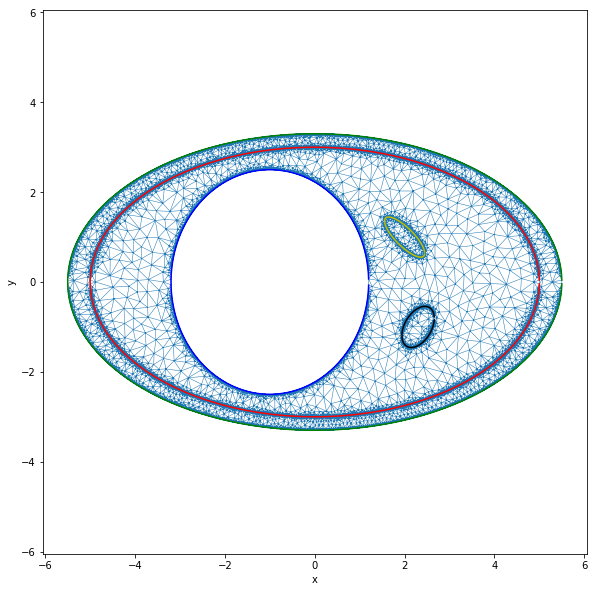

5 3 -1 2.2 2.5 2 1 0.2 0.6 0.7853981633974483 2.3 -1 0.5 0.3 1.0471975511965976


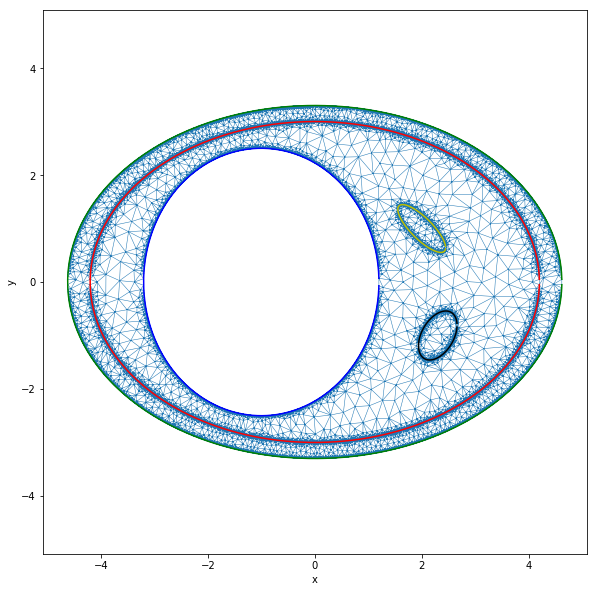

4.2 3 -1 2.2 2.5 2 1 0.2 0.6 0.7853981633974483 2.3 -1 0.5 0.3 1.0471975511965976


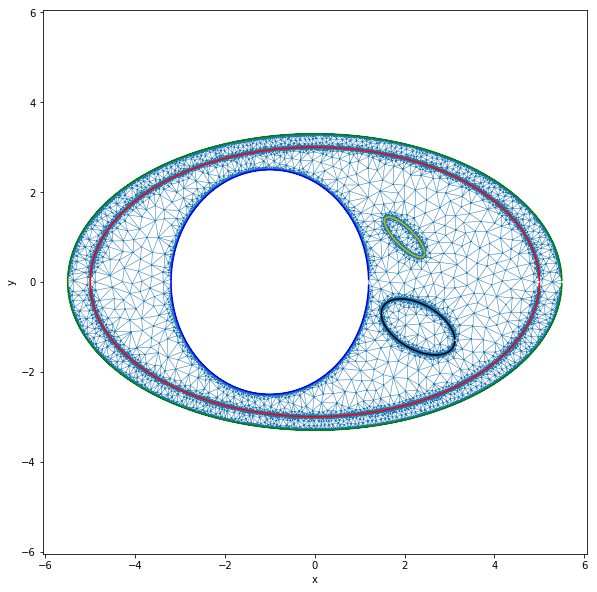

5 3 -1 2.2 2.5 2 1 0.2 0.6 0.7853981633974483 2.3 -1 0.5 0.9 1.0471975511965976


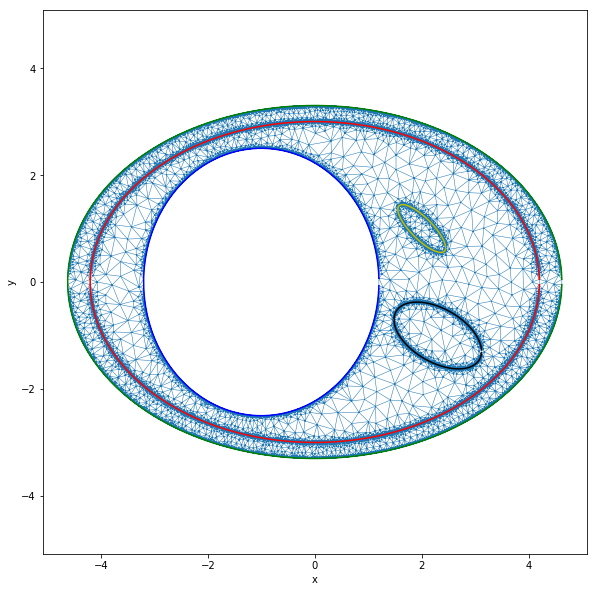

4.2 3 -1 2.2 2.5 2 1 0.2 0.6 0.7853981633974483 2.3 -1 0.5 0.9 1.0471975511965976


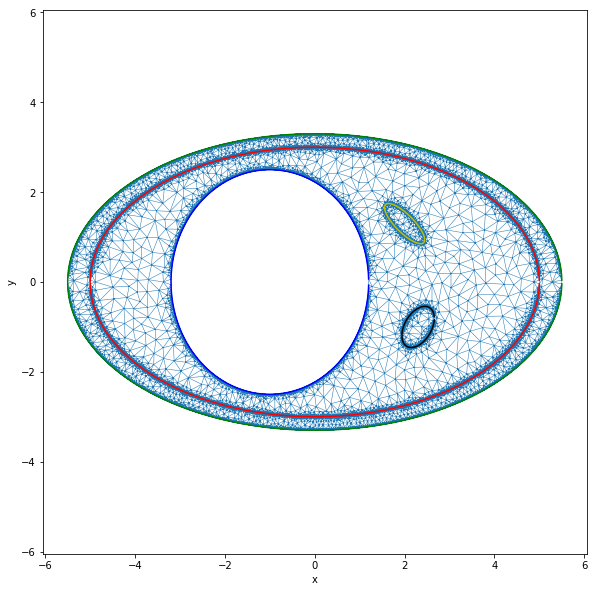

5 3 -1 2.2 2.5 2 1.3 0.2 0.6 0.7853981633974483 2.3 -1 0.5 0.3 1.0471975511965976


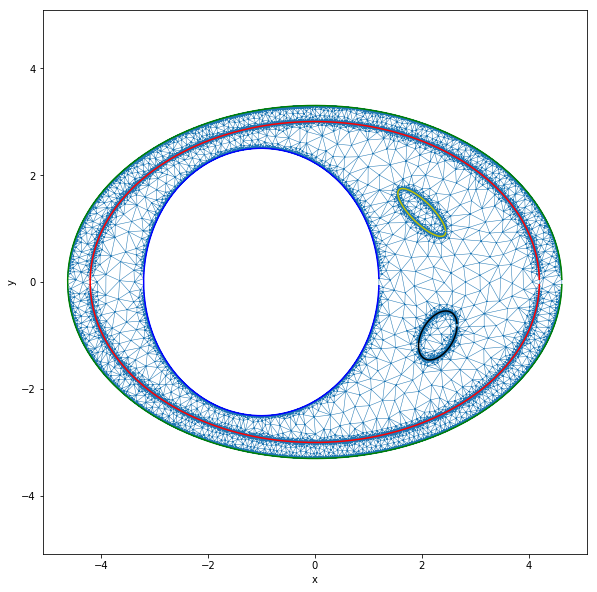

4.2 3 -1 2.2 2.5 2 1.3 0.2 0.6 0.7853981633974483 2.3 -1 0.5 0.3 1.0471975511965976


KeyboardInterrupt: 

In [10]:
import time
t0 = time.time()
count = 0
for x_L in [-1,-1.3]:
    count+=1
    for alpha_lip in [np.pi/3,np.pi]:
        count+=1
        for y_cal in [1, 1.3]:
            count+=1
            for b_lip in [.3,.9]:
                count+=1
                for a_wall_in in [5,4.2]:
                    count+=1
                    artery_plot(a_wall_in, b_wall_in, thick_wall,x_L, a_L, b_L, x_cal, y_cal, a_cal, b_cal, alpha_cal,x_lip, y_lip, a_lip, b_lip, alpha_lip) 
                    print(a_wall_in, b_wall_in,x_L, a_L, b_L, x_cal, y_cal, a_cal, b_cal, alpha_cal,x_lip, y_lip, a_lip, b_lip, alpha_lip)
print("time: %f , arteries try: %d"%(time.time()-t0,count))